## El presente código se corrió correctamente en una tarjeta gráfica "NVIDIA GeForce 940MX de 2GB"

## trabajando con "CUDA Version: 11.3" y con "CuDNN Version: 8.2.1.32" (cudnn-11.3-linux-x64-v8.2.1.32)

## usando las versiones de tensorflow: "tensorflow==2.5.0" y "tensorflow-gpu==2.5.0"

## En caso de error por falta de memoria hay que disminuir el "batch-size" en el entrenamiento

### * Al final veremos como guardar el modelo entrenado para posteriormente poder usarlo y hacer predicciones sin volver a entrenarlo

# Proyecto: Clasificación de imágenes (a color) usando Redes Neuronales Convolucionales

### Usamos la base de datos 'cifar10'

### Los features están clasificados en 10 clases distintas 

### Entrenaremos la red usando la función de costo `loss='sparse_categorical_crossentropy'`

### veremos que con esta función de costo no es necesario codificar los labels (como arreglos 1D)

### Usaremos técnicas de regularización y DropOut para eliminar errores de Overfitting

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical

# base de datos de imagenes a color
from tensorflow.keras.datasets import cifar10

# Librería para separar datos:
from sklearn.model_selection import train_test_split

# Las siguientes líneas resuelven un conflicto de compatibilidad entre versiones de 
# tensorflow para cuda 
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

# Activa la tarjeta grafica:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Cargamos datos de entrenamiento y pruebas:

In [2]:
# Imprimimos las propiedades del hardware usado por Tensorflow:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8984233664575996719
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1460928512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8686249648098681834
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


In [3]:
# cargamos los datos:
(train_data, train_labels), (complement_train_data, complement_train_labels) = cifar10.load_data()

# subdividimos el complemento de los datos de entrenamiento 
# para extraer datos de 'test' y 'validation' 

#  -Datos de entrenamiento: 100% de los datos de entrenamiento
#  -Datos de validation: 50% del complemento de entrenamiento
#  -Datos de test:       50% del complemento de entrenamiento

#p_train = 0.8 # porcentaje de datos de entrenamiento
p_validation=0.5  # porcentaje de datos de validación
p_test=0.5 # porcentaje de datos de pruebas

validation_data, test_data, validation_labels, test_labels = train_test_split (complement_train_data, complement_train_labels, test_size=p_validation, train_size=p_test, random_state=42)

In [4]:
# Imprimimos dimensiones:
print('\nLas dimensiones de los datos de entrenamiento son: ', train_data.shape)
print('Las dimensiones de los labels de entrenamiento son: ', train_labels.shape)

print('\nLas dimensiones de los datos de validación son: ', validation_data.shape)
print('Las dimensiones de los labels de validación son: ', validation_labels.shape)

print('\nLas dimensiones de los datos de prueba son: ', test_data.shape)
print('Las dimensiones de los labels de prueba son: ', test_labels.shape)


Las dimensiones de los datos de entrenamiento son:  (50000, 32, 32, 3)
Las dimensiones de los labels de entrenamiento son:  (50000, 1)

Las dimensiones de los datos de validación son:  (5000, 32, 32, 3)
Las dimensiones de los labels de validación son:  (5000, 1)

Las dimensiones de los datos de prueba son:  (5000, 32, 32, 3)
Las dimensiones de los labels de prueba son:  (5000, 1)


In [5]:
# Las etiquetas toman valores enteros entre 0 y 9, es decir, hay 10 clases posibles
classes = np.unique(train_labels)
print('valores de las clases: ',classes)

n_clases = len(classes)
n_clases

valores de las clases:  [0 1 2 3 4 5 6 7 8 9]


10

In [6]:
# Definimos el nombre de las etiquetas:
class_names = ['avion', 'auto','ave','gato','venado','perro','rana','caballo','barco','camion']

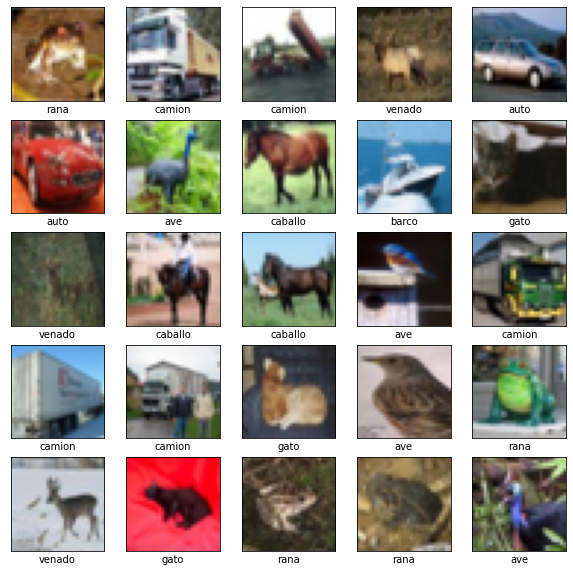

In [7]:
# Visualizamos features de entrenamiento sin estandarizar

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')

    imagen = train_data[i,:,:,:]
    label_imagen = train_labels[i,0]
    nombre_imagen = class_names[ label_imagen ]    

    plt.imshow( imagen, cmap=plt.cm.binary)
    plt.xlabel(nombre_imagen)

## Codificación de features (de entrenamiento, validación y pruebas) que pasarán por la red:

In [8]:
# No modificaremos las dimensiones de los features (cada uno esta en 3D), 
# pues las redes convolucionales se ajustan a estas dimensiones 

x_train = train_data
x_validation = validation_data
x_test = test_data

# normalizamos valores (dividiendo entre el máximo '255') para que los valores esten entre 0 y 1. 
# y los pasamos al tipo 'float32'
x_train = x_train.astype('float32')/255
x_validation = x_validation.astype('float32')/255
x_test = x_test.astype('float32')/255

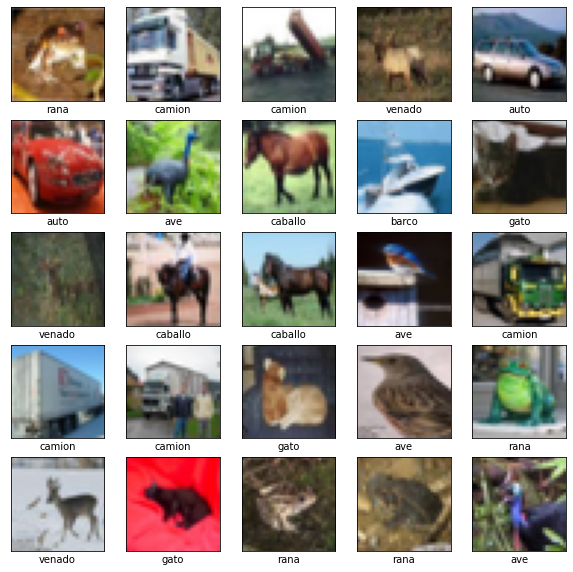

In [9]:
# Visualizamos features de entrenamiento codificados

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')

    imagen = x_train[i,:,:,:]
    label_imagen = train_labels[i,0]
    nombre_imagen = class_names[ label_imagen ]    

    plt.imshow( imagen, cmap=plt.cm.binary)
    plt.xlabel(nombre_imagen)

## Debido a que entrenaremos la red usando la función de costo `loss = sparse_categorical_crossentropy`,
## no es necesario codificar las etiquetas en forma vectorial

In [10]:
y_train = train_labels
y_validation = validation_labels
y_test = test_labels

## Inicia construcción de la arquitectura de la red:

In [11]:
# dimensión de los features para entrenar la red:
dim_feature = x_train[0].shape
dim_feature

(32, 32, 3)

In [12]:
# Creamos la arquitectura de la red:

nn1 = 150 # <-- numero de neuronas para la capa 1
nn2 = 200  # <-- numero de neuronas de la capa 2
nnf = n_clases  # <-- numero de neuronas de la capa de salida (Hay 10 etiquetas posibles)

# Parametros para regularizadores con normas L1 y L2:
alfa_l1 = 0.001 # <-- multiplo del regularizador l1
alfa_l2 = 0.001 # <-- multiplo del regularizador l2

p_active = 0.5 #<--porcentaje de neuronas a activar aleatoriamente en las capas con dropout

# INICIALIZAMOS RED
model = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
# Creamos las capas convolucionales:
model.add( layers.Conv2D(input_shape=(32, 32, 3), kernel_size=(2, 2), padding='same', strides=(2, 2), filters=32) )
model.add( layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same') )
model.add( layers.Conv2D(kernel_size=(2, 2), padding='same', strides=(2, 2), filters=64) )
model.add( layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same') )

# Aplanamos la salida de las capas convolucionales para hacer concexión con redes profundas
model.add( layers.Flatten() )

# Creamos Capas de redes profundas
model.add( layers.Dense(nn1, activation='relu') )
model.add( layers.Dense(nn2, activation='relu', kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)) ) # <-- capa con regularizador
model.add( layers.Dropout(p_active) )#<--- agregamos dropout a la capa anterior
model.add( layers.Dense(nnf, activation='softmax') )

In [13]:
# Compilamos la red neuronal:

# optimizador:
# Si queremos modificar los hiperparámetros debemos poner, por ejemplo para el método 'Nadam':
# optimizer=tf.keras.optimizers.Nadam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
# véase: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# Algunos métodos de ptimización son: 'RMSprop', 'Adam', 'Adamax', 'Nadam', 'SGD'
optim_meth = tf.keras.optimizers.Nadam(learning_rate=0.001)

# función de costo:
# Obs: la función de costo `categorical_crossentropy` se usa para clasificación no binaria y supone que las etiquetas han sido codificadas en arreglos
# la función de costo `sparse_categorical_crossentropy` se usa para clasificación no binaria y no es necesario codificar las etiquetas
loss_func = 'sparse_categorical_crossentropy'

model.compile(
    optimizer= optim_meth,
    loss=loss_func,
    metrics='accuracy'
    )

In [14]:
# visualzamos la arquitecura de la red:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               614550    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               3

In [15]:
# Asignamos un 'batch-size' para saber cuantas iteraciones se realizarán en cada 'epoch'

n_epochs = 20

b_size = 500 #( < 60000) <-- batch-size

n_batches = np.round(x_train.shape[0]/b_size)

print('En cada epoch se realizaran',n_batches, 'iteraciones,')
print('es decir una iteración por cada batch')


En cada epoch se realizaran 100.0 iteraciones,
es decir una iteración por cada batch


In [16]:
# Entrenamos la red:
# Es costoso porque primero se hace la 'Forward propagation'
# posteriormente se calcula el gradiente mediante 'Backward propagation'

train = model.fit(
    x_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=b_size,
    validation_data=(x_validation , y_validation) # <-- agregamos datos para validación
    )

Epoch 1/20
100/100 [==============================] - 9s 60ms/step - loss: 3.0519 - accuracy: 0.3401 - val_loss: 2.0937 - val_accuracy: 0.4766
Epoch 2/20
100/100 [==============================] - 6s 58ms/step - loss: 1.8732 - accuracy: 0.4802 - val_loss: 1.7243 - val_accuracy: 0.4886
Epoch 3/20
100/100 [==============================] - 6s 58ms/step - loss: 1.5898 - accuracy: 0.5296 - val_loss: 1.4338 - val_accuracy: 0.5634
Epoch 4/20
100/100 [==============================] - 6s 58ms/step - loss: 1.4345 - accuracy: 0.5633 - val_loss: 1.3648 - val_accuracy: 0.5890
Epoch 5/20
100/100 [==============================] - 6s 60ms/step - loss: 1.3433 - accuracy: 0.5862 - val_loss: 1.3016 - val_accuracy: 0.6046
Epoch 6/20
100/100 [==============================] - 6s 59ms/step - loss: 1.2754 - accuracy: 0.6078 - val_loss: 1.2047 - val_accuracy: 0.6290
Epoch 7/20
100/100 [==============================] - 6s 59ms/step - loss: 1.2149 - accuracy: 0.6262 - val_loss: 1.1862 - val_accuracy: 0.6312

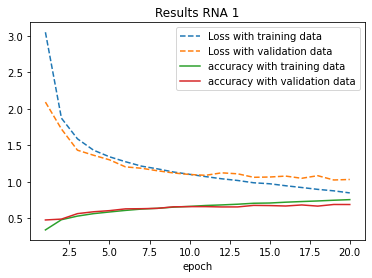

In [17]:
# Extraemos los valores de 'loss' y 'accuracy' obtenido en cada 'epoch':

loss_values_data_train = train.history['loss']# <-- valores del 'loss'
loss_values_data_valid = train.history['val_loss'] #<-- valores del 'loss' (para datos de validacion)
accuracy_values_data_train = train.history['accuracy']# <-- valores del 'loss'
accuracy_values_valid_train = train.history['val_accuracy'] #<-- valores del 'loss' (para datos de validacion)

# numeramos 'epochs' contando desde 1:
epoch = range(1,len(loss_values_data_train)+1)

plt.figure()
plt.plot(epoch, loss_values_data_train, '--', label='Loss with training data')
plt.plot(epoch, loss_values_data_valid, '--', label='Loss with validation data')
plt.plot(epoch, accuracy_values_data_train, label='accuracy with training data')
plt.plot(epoch, accuracy_values_valid_train, label='accuracy with validation data')
plt.legend()
plt.title('Results RNA 1')
plt.xlabel('epoch')
plt.show()

In [18]:
# Obtenemos una medida de la precisión de las predicciones:

# Ya que se encontraron los pesos que minimizan la función de costo (se entrenó la red)
# sólo se hace una 'Forward propagation' con los datos de ptrueba para medir su aprendizaje:
ev = model.evaluate(x_test,y_test)

157/157 [==============================] - 1s 4ms/step - loss: 1.0377 - accuracy: 0.6994


In [19]:
# Obtenemos la precisión de predicción:

test_loss , test_acc = model.evaluate(x_test , y_test)

print('Accuracy = ', test_acc*100, '%')

157/157 [==============================] - 1s 4ms/step - loss: 1.0377 - accuracy: 0.6994
Accuracy =  69.9400007724762 %


In [20]:
loss_train_data = np.mean(loss_values_data_train)
loss_valid_data = np.mean(loss_values_data_valid)

size_overfitting = np.abs(loss_train_data - loss_valid_data)
if size_overfitting < 1:
    print('size_overfitting = ',size_overfitting, '< 1')
    print('No hay overfitting!')
else:
    print('size_overfitting = ',size_overfitting, '> 1')
    print('Hay overfitting: Reducir complejidad de la red o Agregar regularizador o Dropout! ')

size_overfitting =  0.018861213326454074 < 1
No hay overfitting!


## Realizamos  predicciones:

In [21]:
# Obtenemos las etiquetas predichas con los datos de prueba: 
y_predict = model.predict(x_test)

y_predict.shape

(5000, 10)

### Cada etiqueta predicha por la red corresponde a un arreglo de tamaño 10.
### La posición del valor máximo de dicho arreglo corresponde al valor de la etiqueta predicha
### extraemos la posición del valor maximo usando `np.argmax`

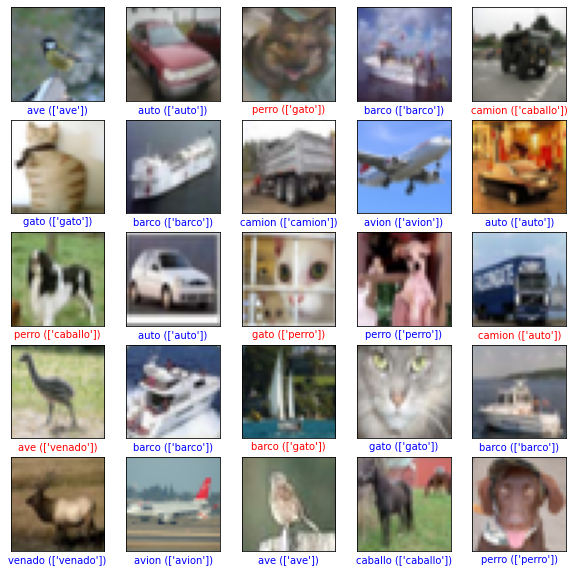

In [22]:
%matplotlib inline

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')   

    true_label =  y_test[i,0]    
    aprox_label = np.argmax( y_predict[i] )

    if true_label == aprox_label:
        col = 'blue'
    else:
        col = 'red'

    imagen = x_test[i,:].reshape(32,32,3)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel('{} ({})'.format( class_names[true_label], [class_names[aprox_label]]), color=col)

# Guardamos el modelo entrenado para usarlo posteriormente sin tener que volver a entrenar:

In [23]:
# Guardamos el modelo:
model.save('modelo_entrenado_RNA3_CIFAR10.h5')